$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

# Problema 2

In [1]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from z3 import *

In [ ]:
def draw_graph (graph):
    node_labels = {}
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "xor":
            node_labels[i] = "$\oplus$"
        elif graph.nodes[i]["type"] == "sum":
            node_labels[i] = "$+$"
        elif graph.nodes[i]["type"] == "shift":
            node_labels[i] = "$\gg_{" + str(graph.nodes[i]["r"]) + "}$"
        else:
            j = [z for k,z in graph.edges if k==i]
            if len(j) == 0:
                node_labels[i] = "out"
            else:
                node_labels[i] = "in"
            
    edge_labels = {(i,j): graph.edges[i,j]["value"] for i,j in graph.edges if "value" in graph.edges[i,j]}
    for i,j in graph.edges:
        if "value" not in graph.edges[i,j]:
            edge_labels[i,j] = "?"
            
    node_colors = []
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "input":
            node_colors.append("green")
        elif graph.nodes[i]["type"] == "output":
            node_colors.append("red")
        else:
            node_colors.append("orange")
            
    f = plt.figure(figsize=(12, 12))
    plt.title("Graph")
    pos = nx.nx_pydot.graphviz_layout(graph)
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    nx.draw(graph, font_size=10, pos=pos, labels=node_labels, node_size=[600 for _ in graph.nodes], node_color=node_colors)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    plt.show()

In [ ]:
def random_binary_tree(N):
    
    # Criar output e primeiro nodo da árvore
    graph = nx.DiGraph()
    graph.add_nodes_from([0, 1])
    graph.add_edges_from([(0, 1)])
    
    # Sempre que ainda puder adicionar um novo nodo
    while len(graph.nodes) < N:
        # Encontrar as folhas da árvore
        leaves = [i for i in graph.nodes if len(list(graph.neighbors(i)))==0]
        np.random.shuffle(leaves)
        
        # Colocar elemento na folha da àrvore
        for i in leaves:
            n = len(graph.nodes)
            if N-n == 0:
                pass
            else:
                num_nodes = min(2, N-n)
                # num_nodes = np.random.randint(1, num_nodes+1)
                nodes = [j for j in range(n, n+num_nodes)]
                edges = [(i, j) for j in nodes]
                graph.add_nodes_from(nodes)
                graph.add_edges_from(edges)
            leaves = [i for i in graph.nodes if len(list(graph.neighbors(i)))==0]
                
    assert len(graph.nodes) == N            
    
    return graph

def random_graph(N, M, gamma, n):
    # Há 1 nodo de output, N de input e N-1 binários
    graph = random_binary_tree(2*N)
    graph.nodes[0]["type"] = "output"
    
    for i in range(2*N, N+M+1):
        j,k = list(graph.edges)[np.random.randint(len(graph.edges))]
        graph.add_nodes_from([i])
        graph.remove_edges_from([(j,k)])
        graph.add_edges_from([(j, i), (i, k)])
    
    """
    # Determinar os input nodes
    no_neighbor_nodes = [i for i in graph.nodes if len(list(graph.neighbors(i)))==0]
    np.random.shuffle(no_neighbor_nodes)
    
    # Remover input nodes se houver a mais
    while len(no_neighbor_nodes) > N:
        neigh = np.random.randint(1, len(no_neighbor_nodes))
        graph.add_edges_from([(no_neighbor_nodes[0], neigh)])
        no_neighbor_nodes.remove(no_neighbor_nodes[0])"""
    
    # Adicionar o tipo às gates binárias
    num_sum, bin_ops = 0, ["sum", "xor"]
    bin_gates = [j for j in list(graph.nodes) if len(list(graph.neighbors(j)))==2]
    np.random.shuffle(bin_gates)
    for i in bin_gates:
        if (num_sum+1)/M <= gamma:
            op = "sum"
        else:
            op = "xor"
        graph.nodes[i]["type"] = op
        
    # Adicionar o tipo às gates de input
    input_nodes = [j for j in list(graph.nodes) if len(list(graph.neighbors(j)))==0]
    for i in input_nodes:
        graph.nodes[i]["type"] = "input"
    
    # Adicionar o tipo às gates de shift
    shift_gates = [j for j in list(graph.nodes) if (j>0 and len(list(graph.neighbors(j)))==1)]
    for i in shift_gates:
        graph.nodes[i]["type"] = "shift"
        graph.nodes[i]["r"] = np.random.randint(1, 16)
        
    # Adicionar o valor da aresta de output
    j = [j for i,j in graph.edges if i==0][0]
    graph.edges[0,j]["value"] = BitVecVal(np.random.randint(2**n), n)
        
    graph = nx.DiGraph.reverse(graph)
    # Adicionar valores aleatórios aos nodos de output e soma
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "sum":
            value = np.random.randint(2**n)
            j = list(graph.neighbors(i))[0]
            graph.edges[i,j]["value"] = BitVecVal(value, n)
        
    return graph

In [ ]:
def l_shift_rot(c, r):
    return (c >> (n-r)) | LShR(c, r)

def solve_circuit(graph):
    H = nx.DiGraph.reverse(graph)
    solver = Solver()

    B = {}
    for i, j in H.edges:
        if "value" not in H.edges[i,j]:
            B[i,j] = BitVec(f"{i},{j}", n)
        else:
            B[i,j] = H.edges[i,j]["value"]

    for i, j in H.edges:
        out = B[i,j]
        if H.nodes[j]["type"] == "xor": # Operação XOR
            nbr1, nbr2 = list(H.neighbors(j))
            a, b = B[j, nbr1], B[j, nbr2]
            solver.add (a^b == out)
        elif H.nodes[j]["type"] == "shift": # Operação Right-Shift-Rotate
            nbr = list(H.neighbors(j))[0]
            a = B[j, nbr]
            solver.add (l_shift_rot(a, H.nodes[j]["r"]) == out)
        elif H.nodes[j]["type"] == "sum": # Operação soma
            nbr1, nbr2 = list(H.neighbors(j))
            a, b = B[j, nbr1], B[j, nbr2]
            solver.add (a+b == out)
        elif H.nodes[j]["type"] == "wire":
            nbr = list(H.neighbors(j))[0]
            solver.add(out == B[j, nbr])

    if solver.check() == sat:
        print ("Os dados são consistentes")
        m = solver.model()
        for i,j in B:
            if m[B[i,j]] != None:
                H.edges[i,j]["value"] = m[B[i,j]]

        graph = nx.DiGraph.reverse(H)
        draw_graph(graph)
        r = graph
    else:
        # print ("Os dados não são consistentes")
        r = None
        
    return r

In [ ]:
N, M, gamma, n = 7, 12, 0, 16

while True:
    G = random_graph(N, M, gamma, n)
    G = solve_circuit(G)
    if G != None:
        break

In [ ]:
n = 16

G = nx.DiGraph()
G.add_nodes_from([i for i in range(12)])
G.add_edges_from([(1, 0), (2, 1), (3, 1), (6, 3), (4, 2), (5, 2), (7, 3), (8, 7), (9, 5), (10, 4), (11, 6)])

G.nodes[0]["type"] = "output"
G.edges[1,0]["value"] = BitVecVal(np.random.randint(2**16), n)
# G.edges[1,0]["value"] = 10
for i in [8, 9, 10, 11]:
    G.nodes[i]["type"] = "input"
for i in [2, 3]:
    G.nodes[i]["type"] = "xor"
for i in [4, 5, 6, 7]:
    G.nodes[i]["type"] = "shift"
    G.nodes[i]["r"] = np.random.randint(1, 16)
G.nodes[1]["type"] = "sum"
G.nodes[1]["value"] = BitVecVal(10, n)
    
draw_graph(G)

In [ ]:
R = random_binary_tree (6 + 10 + 1)
f = plt.figure(figsize=(12, 12))
plt.title("Graph")
pos = nx.nx_pydot.graphviz_layout(R)
pos = nx.nx_pydot.graphviz_layout(R, prog="dot")
nx.draw(R, font_size=10, pos=pos, with_labels=True, node_size=[600 for _ in R.nodes])
plt.show()

In [2]:
def init_circuito(N, M, gamma):
    # Número aleatório de gates e wires
    n_w = np.random.randint(N+1)
    n_b = np.random.randint(M+1)
    n_u = M - n_b

    # Inicializar o grafo
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(N+M+1+n_w)])
    G.nodes[0]["type"] = "output"

    # Dar os tipos aos nodos
    conta = 0
    for i in range(1, N+1):
        G.nodes[i]["type"] = "input"
        conta += 1
    assert conta == N    

    conta = 0
    for i in range(N+n_b+1, N+M+1):
        G.nodes[i]["type"] = "shift"
        conta += 1
    assert conta == n_u    

    conta = 0
    for i in range(N+M+1, len(G.nodes)):
        G.nodes[i]["type"] = "wire"
        conta += 1
    assert conta == n_w
    
    return G

def solve_graph(graph):
    solver = Solver()
    A = {(i,j): Int(f"{i},{j}") for i in range(len(graph.nodes)) for j in range(len(graph.nodes))}

    # Ou há ligação ou não há
    for i,j in A:
        solver.add(A[i,j]>=0, A[i,j]<=1)

    # Restrições para a saída de cada tipo
    for i in graph.nodes:
        if "type" not in graph.nodes[i]:
            solver.add(Sum([A[i,j] for j in range(len(graph.nodes))]) == 1)
            solver.add(Sum([A[j,i] for j in range(len(graph.nodes))]) == 2)
        elif graph.nodes[i]["type"] == "output":
            solver.add(Sum([A[i,j] for j in range(len(graph.nodes))]) == 0)
            solver.add(Sum([A[j,i] for j in range(len(graph.nodes))]) == 1)
        elif graph.nodes[i]["type"] == "input":
            solver.add(Sum([A[i,j] for j in range(len(graph.nodes))]) == 1)
            solver.add(Sum([A[j,i] for j in range(len(graph.nodes))]) == 0)
            solver.add(A[i,0]==0)
        elif graph.nodes[i]["type"] == "wire":
            solver.add(Sum([A[i,j] for j in range(len(graph.nodes))]) >= 1)
            solver.add(Sum([A[j,i] for j in range(len(graph.nodes))]) == 1)
        else:
            solver.add(Sum([A[i,j] for j in range(len(graph.nodes))]) == 1)
            solver.add(Sum([A[j,i] for j in range(len(graph.nodes))]) == 1)

    # Não existem ligações de um nodo para si mesmo
    solver.add(Sum([A[i,i] for i in graph.nodes])==0)
    
    # Não existem ligações bidirecionais
    for i,j in A:
        solver.add(A[i,j]+A[j,i]<=1)

    if solver.check() == sat:
        print("Satisfiable")
        m = solver.model()
        edges = [(i,j) for i,j in A if m[A[i,j]]==1]
        graph.add_edges_from(edges)
        r = graph
    else:
        # print("Not satisfiable")
        r = None
        
    return r

Satisfiable
Satisfiable
Satisfiable


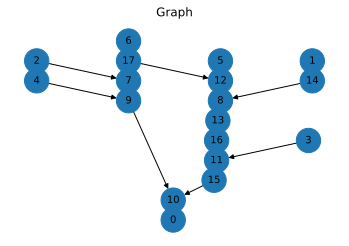

In [3]:
N, M, gamma = 6, 10, 0

while True:
    G = solve_graph(init_circuito(N, M, gamma))
    if G != None:
        
        conta_nodos = 0
        for i in G.nodes:
            if "type" in G.nodes[i] and G.nodes[i]["type"]=="input":
                paths = list(nx.all_simple_paths(G, i, 0))
                if len(paths) == 0:
                    break
                else:
                    conta_nodos += 1
                    
        if conta_nodos == N:
            try:
                nx.find_cycle(G, orientation="original")
            except:
                break
        
plt.title("Graph")
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
nx.draw(G, font_size=10, pos=pos, with_labels=True, node_size=[600 for _ in G.nodes])
plt.show()

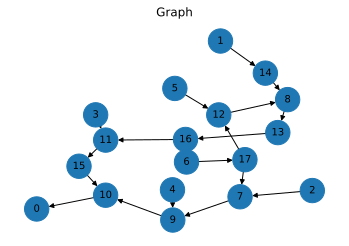

In [4]:
plt.title("Graph")
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="fdp")
nx.draw(G, font_size=10, pos=pos, with_labels=True, node_size=[600 for _ in G.nodes])
plt.show()